# Ray Data

In this notebook we are going to explore the following topics:  

- Ray Datasets;
- Ray Data - Api (Read, add columns, groupby operations, etc);

The dataset used in this notebook is in the following dir `/leonardo_scratch/fast/tra26_castiel2/data/ray_data`.  

# Introduction to Ray Data
Ray data is a Ray component based on the Ray Core functionalities presented in the notebook `1_ray_core.ipynb`. Ray data provides functions for scalable data processing, batch inference, and distributed training. For an example about video processing, check [this](https://www.anyscale.com/blog/streaming-distributed-execution-across-cpus-and-gpus).  

The basic building block of Ray Data are Ray Datasets. Datasets are abstractions used to represent a distributed data collection.  

IMPORTANT NOTE: At the moment, Ray Data doesn't support the presence of a Ray Client connecting to a remote cluster. To solve this issue, all `ray.data` operations will be encapsuled inside Ray tasks. In this way, the task will be sent to the cluster and the ray data operations will be executed by the worker nodes.  

# Imports

In [1]:
from datetime import datetime

import ray
from ray.util.actor_pool import ActorPool
import ray.data

import pandas as pd
import matplotlib.pyplot as plt

/leonardo_work/tra26_castiel2/mviscia1/ray_rag_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-29 08:02:15,848	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-01-29 08:02:33,850	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Environment configuration

In [2]:
ray.init(log_to_driver = False, ignore_reinit_error = True)
print(f"Notebook started {datetime.now()}")

2026-01-29 08:02:37,326	INFO worker.py:1520 -- Using address 10.11.1.34:23707 set in the environment variable RAY_ADDRESS
2026-01-29 08:02:37,327	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.11.1.34:23707...
2026-01-29 08:02:37,336	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at http://10.11.1.34:8265 


Notebook started 2026-01-29 08:02:38.866136


In [3]:
resources = ray.cluster_resources()
print(f"Cluster has {resources['CPU']} CPUs, {resources['GPU'] if 'GPU' in resources else 0} GPUs, execution memory {resources['memory'] * 1e-9} GBs, object storage memory {resources['object_store_memory'] * 1e-9} GBs")

Cluster has 8.0 CPUs, 1.0 GPUs, execution memory 361.684707328 GBs, object storage memory 155.007731712 GBs


# Ray Data - Datasets  
Ray Data supports data ingestion out of the box for the most common data formats (i.e. parquet, csv, json files, images, binary files, etc), and it supports reading data from cloud storage devices.  
To speed up the reading operations, you want your data in a location readable from all workers. In this way, the loading will be parallelized using all the available workers.  

In [4]:
DATA_PATH = "/leonardo_scratch/fast/tra26_castiel2/data/ray_data"

df = ray.data.read_csv(DATA_PATH).limit(1e6).repartition(int(resources["CPU"])).materialize()
df

2026-01-29 08:02:47,655	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:02:47,656	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> LimitOperator[limit=1000000.0] -> AllToAllOperator[Repartition]
Running 0: 0.00 row [00:00, ? row/s]
eadCSV 1: 0.00 row [00:00, ? row/s]

t=1000000.0 2: 0.00 row [00:00, ? row/s]


tion 3: 0.00 row [00:00, ? row/s]



Running Dataset. Active & requested resources: 5/8 CPU, 1.2GB/72.2GB object store: : 0.00 row [00:01, ? row/s]
eadCSV: Tasks: 5 [backpressured]; Queued blocks: 1253; Resources: 5.0 CPU, 1.2GB object store: : 0.00 row [00:01, ? row/s]
eadCSV: Tasks: 5 [backpressured]; Queued blocks: 1253; Resources: 5.0 CPU, 1.2GB object store: : 0.00 row [00:01, ? row/s]

t=1000000.0: Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 0.0B object store: : 0.00 row [00:01, ? row/s]



MaterializedDataset(
   num_blocks=8,
   num_rows=1000000,
   schema={
      human_readable_ts: timestamp[s],
      id: int64,
      state: string,
      transaction_amount: double,
      transaction_category: string,
      unix_timestamp: int64
   }
)

# Ray Data - API

In the previous cells a million rows were read in parallell. By default all the operations on datasets are executed lazily, to force the ingestion of the dataset we can use the `materialize` method. This triggers the execution of the `read_csv` method and pins the dataset blocks in the distributed object storage. Other operations which trigger data reading are operations like `take_batch`, `write_csv`, etc.  

Datasets in Ray are divided into blocks that are processed independently. Each block is read into memory as required, making it possible to handle datasets larger than memory by processing blocks in parallel on different workers.  

We can obtain information about the dataset using the following commands:  
- `.columns()`: get a list with the colnames;
- `.count()`: get a count of the rows included in the dataset;
- `.size_bytes()`: get the size in bytes of the dataset;
- `.num_blocks()`: get the number of blocks in which the dataset is scattered.  

In [5]:
cols = df.columns()
rows = df.count()
bytes = df.size_bytes()
n_blocks = df.num_blocks()
print(f"Dataset has {len(cols)} columns, {rows} rows. Dataset memory occupation is {bytes * 1e-9:.2f}GB and is scattered in {n_blocks} blocks.")

Dataset has 6 columns, 1000000 rows. Dataset memory occupation is 0.06GB and is scattered in 8 blocks.


With the `take_batch` method we can ask a batch of dataset rows, this is very useful if you need to debug something.  
The `batch_format` parameters is used to express how you want your batch to be returned. Supported batch formats are:
- pandas;
- numpy;
- default (dictionay).

In [6]:
df.take_batch(10, batch_format = "pandas")

2026-01-29 08:02:52,031	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:02:52,032	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=10]
Running 0: 0.00 row [00:00, ? row/s]
                                                                             
✔️  Dataset execution finished in 0.02 seconds: : 10.0 row [00:00, 531 row/s]

imit=10 1: 0.00 row [00:00, ? row/s]
imit=10: Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 581.0B object store: : 0.00 row [00:00, ? row/s]
imit=10: Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 581.0B object store: : 10.0 row [00:00, 471 row/s]
- limit=10: Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 581.0B object store: : 10.0 row [00:00, 418 row/s]


,human_readable_ts,id,state,transaction_amount,transaction_category,unix_timestamp
0,2011-01-04 12:26:51,445278366,Texas,48.804656,Utilities,1294140411
1,2004-08-20 04:32:17,445278367,Mississippi,67.424309,Gas Station,1092969137
2,1982-03-12 20:27:34,445278368,Wisconsin,29.831828,Electronics,384809254
3,1985-07-16 02:22:11,445278369,Virginia,51.495818,Utilities,490321331
4,2023-02-07 06:43:35,445278370,Ohio,53.365462,Electronics,1675748615
5,1994-12-15 09:16:08,445278371,Maryland,66.733325,Gas Station,787479368
6,1991-03-17 12:30:34,445278372,Pennsylvania,62.746037,Restaurant,669209434
7,2020-01-26 14:08:10,445278373,Maryland,113.996035,Electronics,1580044090
8,1987-07-04 21:31:10,445278374,Texas,66.904820,Restaurant,552425470
9,2018-05-08 22:40:20,445278375,Georgia,80.782422,Supermarket,1525812020


We can drop useless columns with `drop_columns`.

In [7]:
df.columns

<bound method Dataset.columns of MaterializedDataset(
   num_blocks=8,
   num_rows=1000000,
   schema={
      human_readable_ts: timestamp[s],
      id: int64,
      state: string,
      transaction_amount: double,
      transaction_category: string,
      unix_timestamp: int64
   }
)>

In [8]:
df_1 = df.drop_columns(["unix_timestamp"])
df_1.take_batch(10, batch_format="pandas")

2026-01-29 08:02:52,370	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:02:52,370	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(drop_columns)] -> LimitOperator[limit=10]
Running 0: 0.00 row [00:00, ? row/s]
apBatches(drop_columns) 1: 0.00 row [00:00, ? row/s]

                                                                                                   
                                                    

✔️  Dataset execution finished in 0.08 seconds: 100%|██████████| 10.0/10.0 [00:00<00:00, 117 row/s]

apBatches(drop_columns) 1: 0.00 row [00:00, ? row/s]

t=10 2: 0.00 row [00:00, ? row/s]
apBatches(drop_columns): Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 0.0B object store: : 0.00 row [00:00, ? row/s]
apBatches(drop_columns): Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 0.0B object store

,human_readable_ts,id,state,transaction_amount,transaction_category
0,2011-01-04 12:26:51,445278366,Texas,48.804656,Utilities
1,2004-08-20 04:32:17,445278367,Mississippi,67.424309,Gas Station
2,1982-03-12 20:27:34,445278368,Wisconsin,29.831828,Electronics
3,1985-07-16 02:22:11,445278369,Virginia,51.495818,Utilities
4,2023-02-07 06:43:35,445278370,Ohio,53.365462,Electronics
5,1994-12-15 09:16:08,445278371,Maryland,66.733325,Gas Station
6,1991-03-17 12:30:34,445278372,Pennsylvania,62.746037,Restaurant
7,2020-01-26 14:08:10,445278373,Maryland,113.996035,Electronics
8,1987-07-04 21:31:10,445278374,Texas,66.904820,Restaurant
9,2018-05-08 22:40:20,445278375,Georgia,80.782422,Supermarket


We can add new columns using the `add_column` function. Remember that also transformations in Ray Data are executed lazily, and are recorded in a computation graph. The actual execution only occurs when non-delayable operations are triggered (e.g. `write_csv`, `take_batch`, `materialize`, etc).  

In [9]:
df_2 = df.add_column("dollars", lambda x: x["transaction_amount"].map(lambda x: int(x)))
df_2.take_batch(10, batch_format="pandas")

2026-01-29 08:02:52,483	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:02:52,484	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(add_column)] -> LimitOperator[limit=10]
Running 0: 0.00 row [00:00, ? row/s]
apBatches(add_column) 1: 0.00 row [00:00, ? row/s]

                                                                                                    
                                                  

✔️  Dataset execution finished in 0.54 seconds: 100%|██████████| 10.0/10.0 [00:00<00:00, 18.3 row/s]

apBatches(add_column) 1: 0.00 row [00:00, ? row/s]

t=10 2: 0.00 row [00:00, ? row/s]
apBatches(add_column): Tasks: 2; Queued blocks: 0; Resources: 2.0 CPU, 37.1MB object store: : 0.00 row [00:00, ? row/s]
apBatches(add_column): Tasks: 2; Queued blocks: 0; Resources: 2.0 CPU, 37.1MB object store:   0%

,human_readable_ts,id,state,transaction_amount,transaction_category,unix_timestamp,dollars
0,2011-01-04 12:26:51,445278366,Texas,48.804656,Utilities,1294140411,48
1,2004-08-20 04:32:17,445278367,Mississippi,67.424309,Gas Station,1092969137,67
2,1982-03-12 20:27:34,445278368,Wisconsin,29.831828,Electronics,384809254,29
3,1985-07-16 02:22:11,445278369,Virginia,51.495818,Utilities,490321331,51
4,2023-02-07 06:43:35,445278370,Ohio,53.365462,Electronics,1675748615,53
5,1994-12-15 09:16:08,445278371,Maryland,66.733325,Gas Station,787479368,66
6,1991-03-17 12:30:34,445278372,Pennsylvania,62.746037,Restaurant,669209434,62
7,2020-01-26 14:08:10,445278373,Maryland,113.996035,Electronics,1580044090,113
8,1987-07-04 21:31:10,445278374,Texas,66.904820,Restaurant,552425470,66
9,2018-05-08 22:40:20,445278375,Georgia,80.782422,Supermarket,1525812020,80


You can achieve the same results of the previous cell with better flexibility using map batches with a user defined function.  
The function will receive a batch of data in the specified format. In this case, a `pandas` dataset.  

In [10]:
def parse_in_batches(df_batch):
    df_batch["year"] = df_batch["human_readable_ts"].map(lambda x: x.year)
    df_batch["month"] = df_batch["human_readable_ts"].map(lambda x: x.month)
    df_batch["day"] = df_batch["human_readable_ts"].map(lambda x: x.day)
    df_batch["is_leap"] = (df_batch["month"] == 2) & (df_batch["day"] == 29)
    return df_batch

df_3 = df_2.map_batches(parse_in_batches, batch_format = "pandas")
df_3.take_batch(10, batch_format="pandas")

2026-01-29 08:02:53,061	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:02:53,061	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(add_column)->MapBatches(parse_in_batches)] -> LimitOperator[limit=10]
Running 0: 0.00 row [00:00, ? row/s]
apBatches(add_column)->MapBatches(parse_in_batches) 1: 0.00 row [00:00, ? row/s]

t=10 2: 0.00 row [00:00, ? row/s]

t=10: Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 1.9KB object store: : 0.00 row [00:01, ? row/s]

t=10: Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 1.9KB object store:   0%|          | 0.00/10.0 [00:01<?, ? row/s]

t=10: Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 1.9KB object store: 100%|██████████| 10.0/10.0 [00:01<00:00, 9.69 row/s]

Running Dataset. Active & requested resources: 2/8 CPU, 171.7MB/72.2GB object store: 100%|██████████| 10.0/10.

,human_readable_ts,id,state,transaction_amount,transaction_category,unix_timestamp,dollars,year,month,day,is_leap
0,2011-01-04 12:26:51,445278366,Texas,48.804656,Utilities,1294140411,48,2011,1,4,False
1,2004-08-20 04:32:17,445278367,Mississippi,67.424309,Gas Station,1092969137,67,2004,8,20,False
2,1982-03-12 20:27:34,445278368,Wisconsin,29.831828,Electronics,384809254,29,1982,3,12,False
3,1985-07-16 02:22:11,445278369,Virginia,51.495818,Utilities,490321331,51,1985,7,16,False
4,2023-02-07 06:43:35,445278370,Ohio,53.365462,Electronics,1675748615,53,2023,2,7,False
5,1994-12-15 09:16:08,445278371,Maryland,66.733325,Gas Station,787479368,66,1994,12,15,False
6,1991-03-17 12:30:34,445278372,Pennsylvania,62.746037,Restaurant,669209434,62,1991,3,17,False
7,2020-01-26 14:08:10,445278373,Maryland,113.996035,Electronics,1580044090,113,2020,1,26,False
8,1987-07-04 21:31:10,445278374,Texas,66.904820,Restaurant,552425470,66,1987,7,4,False
9,2018-05-08 22:40:20,445278375,Georgia,80.782422,Supermarket,1525812020,80,2018,5,8,False


2026-01-29 08:02:54,146	WARNING progress_bar.py:120 -- Truncating long operator name to 100 characters. To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.

apBatches(add_column)->...->MapBatches(drop_leap): Tasks: 8 [backpressured]; Queued blocks: 0; Resources: 8.0 CPU, 2.0GB object store: : 0.00 row [00:01, ? row/s]
Running Dataset. Active & requested resources: 8/8 CPU, 2.0GB/72.2GB object store: : 0.00 row [00:01, ? row/s].0 CPU, 2.0GB object store: : 0.00 row [00:01, ? row/s]

We can filter out rows based on few conditions using the `filter` function or using normal pandas functions.

In [11]:
def drop_leap(df_batch:pd.DataFrame):
    return df_batch[~df_batch["is_leap"]]

df_4 = df_3.map_batches(drop_leap, batch_format = "pandas").materialize()
df_4

2026-01-29 08:02:54,135	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:02:54,135	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(add_column)->MapBatches(parse_in_batches)->MapBatches(drop_leap)]
Running 0: 0.00 row [00:00, ? row/s]
                                                                                                              
✔️  Dataset execution finished in 1.10 seconds: 100%|██████████| 999k/999k [00:01<00:00, 903k row/s]                                                                 

apBatches(add_column)->...->MapBatches(drop_leap): Tasks: 8 [backpressured]; Queued blocks: 0; Resources: 8.0 CPU, 2.0GB object store: : 0.00 row [00:01, ? row/s]
apBatches(add_column)->...->MapBatches(drop_leap): Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 179.9MB object store: : 0.00 row [00:01, ? 

MaterializedDataset(
   num_blocks=8,
   num_rows=999304,
   schema={
      human_readable_ts: datetime64[s],
      id: int64,
      state: object,
      transaction_amount: float64,
      transaction_category: object,
      unix_timestamp: int64,
      dollars: int64,
      year: int64,
      month: int64,
      day: int64,
      is_leap: bool
   }
)

In [12]:
# Total leap tx dropped
df_3.count() - df_4.count()

2026-01-29 08:02:55,265	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:02:55,266	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(add_column)->MapBatches(parse_in_batches)] -> AggregateNumRows[AggregateNumRows]
Running 0: 0.00 row [00:00, ? row/s]
apBatches(add_column)->MapBatches(parse_in_batches) 1: 0.00 row [00:00, ? row/s]

                                                                              
                                                                                

✔️  Dataset execution finished in 0.91 seconds: : 1.00 row [00:00, 1.09 row/s]

apBatches(add_column)->MapBatches(parse_in_batches) 1: 0.00 row [00:00, ? row/s]

egateNumRows 2: 0.00 row [00:00, ? row/s]
apBatches(add_column)->MapBatches(parse_in_batches): Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 0.0B object store: :

696

In [13]:
%%time
def get_txs_specific_category(df_batch:pd.DataFrame, category:str):
    return df_batch[(df_batch["transaction_category"] == category) & (df_batch["year"] == 1970)]

gas_expenses = df_4.map_batches(get_txs_specific_category, batch_format = "pandas", fn_args=["Gas Station"]).materialize().take_all()
gas_expenses = pd.DataFrame(gas_expenses)
gas_expenses.head()

2026-01-29 08:02:56,202	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:02:56,202	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(get_txs_specific_category)]
Running 0: 0.00 row [00:00, ? row/s]
                                                                                                       
✔️  Dataset execution finished in 0.04 seconds: 100%|██████████| 3.01k/3.01k [00:00<00:00, 77.0k row/s]

apBatches(get_txs_specific_category) 1: 0.00 row [00:00, ? row/s]
apBatches(get_txs_specific_category): Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 560.1KB object store: : 0.00 row [00:00, ? row/s]
apBatches(get_txs_specific_category): Tasks: 0; Queued blocks: 0; Resources: 0.0 CPU, 560.1KB object store:   0%|          | 0.00/3.01k [00:00<?, ? row/s]
apBatches(get_txs_specific_category): Tasks: 0; Queued 

CPU times: user 7.57 s, sys: 138 ms, total: 7.7 s
Wall time: 7.74 s


,human_readable_ts,id,state,transaction_amount,transaction_category,unix_timestamp,dollars,year,month,day,is_leap
0,1970-05-18 10:46:30,445278450,Virginia,73.834990,Gas Station,11871990,73,1970,5,18,False
1,1970-04-23 14:57:14,445279317,Wisconsin,69.104664,Gas Station,9727034,69,1970,4,23,False
2,1970-04-01 08:58:56,445279906,California,68.527096,Gas Station,7804736,68,1970,4,1,False
3,1970-10-17 00:57:52,445279952,Indiana,78.796898,Gas Station,24969472,78,1970,10,17,False
4,1970-06-04 03:59:47,445280413,Wisconsin,73.422859,Gas Station,13316387,73,1970,6,4,False


We can apply groupby operations to our dataset using the `groupby` operator. However, consider that the grouped data must fit in the memory of a single node (i.e. it must be possible to store all the data referring to Alabama 1970 in a single node, etc.). 

In [14]:
stats = pd.DataFrame(df_4.groupby(key = ["state", "year"]).count().take_all())
stats.head()

2026-01-29 08:03:03,962	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:03:03,963	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> AllToAllOperator[Aggregate]
Running 0: 0.00 row [00:00, ? row/s]
ggregate 1: 0.00 row [00:00, ? row/s]

ample 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]


ap 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]



ce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]


fle Map:   0%|          | 0.00/1.00 [00:01<?, ? row/s]


fle Map:   0%|          | 0.00/1.00 [00:01<?, ? row/s]


fle Map:   0%|          | 0.00/1.00 [00:02<?, ? row/s]


fle Map:   0%|          | 0.00/1.00 [00:03<?, ? row/s]


fle Map:   0%|          | 0.00/1.00 [00:04<?, ? row/s]


fle Map:   0%|          | 0.00/1.00 [00:05<?, ? row/s]


fle Map:   0%|          | 0.00/1.00 [00:06<?, ? row/s]


fle Map:   0%|          | 0.00/1.00 [00:07<?, ? 

,state,year,count()
0,Alabama,1970,283
1,Alabama,1971,252
2,Alabama,1972,279
3,Alabama,1973,280
4,Alabama,1974,264


After processing the data using the Ray workers, we can move the results on the client and continue to do our work.  

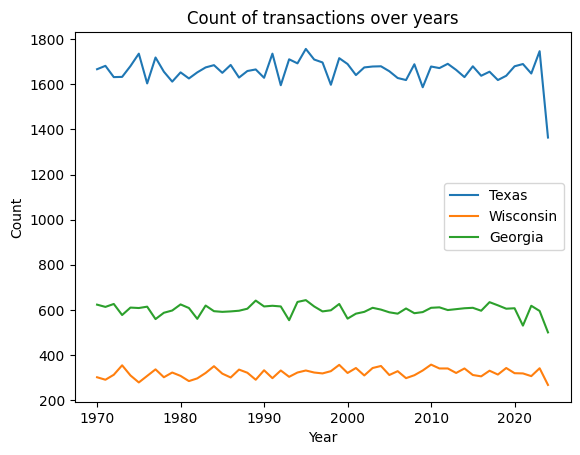

In [15]:
for state in ["Texas", "Wisconsin", "Georgia"]:
    subset = stats[stats["state"] == state]
    plt.plot(subset["year"], subset["count()"], label = state)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.title("Count of transactions over years")

Similarly to `map_batches` we can map arbitrarly complex functions to groups with `map_groups`.  

In [16]:
# For each year and tx category, get the state in which 
# it happened the first transaction of the year
def fist_transaction_of_year(df:pd.DataFrame):
    # Sort by date
    df.sort_values(by="unix_timestamp", inplace=True)
    return df.iloc[:1, :]
    
first_of_the_year = df_4.groupby(key=["year", "transaction_category"]).map_groups(fist_transaction_of_year, batch_format = "pandas").take_all()
first_of_the_year = pd.DataFrame(first_of_the_year)
first_of_the_year.head()

2026-01-29 08:03:54,569	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-29_07-44-12_707538_3508558/logs/ray-data
2026-01-29 08:03:54,570	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> AllToAllOperator[Sort] -> TaskPoolMapOperator[MapBatches(fist_transaction_of_year)]
Running 0: 0.00 row [00:00, ? row/s]
ort 1: 0.00 row [00:00, ? row/s]

ample 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]


ap 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]



ce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]




                                                                                                 
                                

                                                      


                                                   



                                                   




✔️  Dataset execution finished in 1.03 seconds: 100%|██████████| 330/330 [00:01<00:00, 243 row

,human_readable_ts,id,state,transaction_amount,transaction_category,unix_timestamp,dollars,year,month,day,is_leap
0,1970-01-01 07:40:29,444992194,Maryland,2.029032,Bar,24029,2,1970,1,1,False
1,1970-01-01 03:31:03,445241344,North Carolina,64.604061,Electronics,9063,64,1970,1,1,False
2,1970-01-01 01:03:52,445081263,Tennessee,56.808570,Gas Station,232,56,1970,1,1,False
3,1970-01-01 01:37:01,445347932,Tennessee,66.079686,Restaurant,2221,66,1970,1,1,False
4,1970-01-01 04:39:12,445472208,California,83.857468,Supermarket,13152,83,1970,1,1,False


Finally, when we are happy with our transformations we can write data on disk using `write_{something}` command. The same considerations made for `read_csv` are valid also in this case.  

In [17]:
#df_4.limit(100).write_csv(OUTPUT_PATH)

# Exercises
- Get the sum of all transactions about Restaurants for the state of Texas during 1970
- Get the std for the Gas Station transactions in Ohio during 1971
- How would you use an llm to create a description for the transactions? Try to write some code to accomplish this task following [this](https://docs.ray.io/en/latest/data/batch_inference.html#end-to-end-offline-batch-inference) example.  

# Release resources

In [18]:
ray.shutdown()